### 1. Create a basic tensorflow model to generate initial weights

In [1]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

tf.random.set_seed(42) 

# Define a simple model
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(12, activation='relu'),
    Dense(12, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


2024-10-18 15:46:46.548037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 15:46:48.453492: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-10-18 15:46:51.962444: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### 2. Extract weights from the base model

In [2]:
weights = []
biases = []
for i in range(1, len(model.layers)):
    weights.append(model.layers[i].get_weights()[0].T)
    biases.append(model.layers[i].get_weights()[1].T)

print(weights[0].shape, biases[0].shape)
print(weights[1].shape, biases[1].shape)
print(weights[2].shape, biases[2].shape)

(12, 784) (12,)
(12, 12) (12,)
(10, 12) (10,)


### 3. Clean the weights and convert them to cupy arrays for the base model

Cupy is a python library equivalent to numpy that performs operations using the system's GPU as opposed to the CPU

In [3]:
import cupy as cp
weights_base = []

for i in range(len(weights)):
    weights_base.append(cp.hstack([biases[i].reshape(biases[i].shape[0], 1), weights[i]]))

print(weights_base[0].shape)
print(weights_base[1].shape)
print(weights_base[2].shape)

(12, 785)
(12, 13)
(10, 13)


### 4.Load and execute the hard coded base model using the cleaned weights

In [6]:
import base_nn as base

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
x_train = x_train / 255.0
x_test = x_test / 255.0

#flatten the dataset
x_train_flat = x_train.reshape(x_train.shape[0], 28 * 28)
x_test_flat = x_test.reshape(x_test.shape[0], 28 * 28)

#append 1s to multiply with biases
ones_column = cp.ones((x_train_flat.shape[0], 1))
x_train_flat = cp.hstack((ones_column, x_train_flat)).T

train_size = int(0.8 * x_train_flat.shape[1])  # 48000

x_val = x_train_flat[:, train_size:]     # Last 12000 columns for validation
x_train_flat = x_train_flat[:, :train_size]   # First 48000 columns for training
print("X_train Shape: ", x_train_flat.shape)
print("X_Val Shape: ", x_val.shape)

ones_column = cp.ones((x_test_flat.shape[0], 1))
x_test_flat = cp.hstack((ones_column, x_test_flat)).T
print("X_test Shape: ", x_test_flat.shape)

y_train = cp.eye(10)[y_train].T #convert to one hot encoded vectors

y_val = y_train[:, train_size:]
y_train = y_train[:, :train_size]

print("Y_Train Shape: ", y_train.shape)
print("Y_Val Shape: ", y_val.shape)

y_test = cp.eye(10)[y_test].T #convert to one hot encoded vectors
print("Y_Test Shape: ", y_test.shape)


epochs = 5
batch_size = 40
num_samples = x_train_flat.shape[1]

def get_batches(X, Y, batch_size):
    """
    Generator that yields batches from input matrix X and labels Y.
    X: Input data of shape (n_features, n_samples)
    Y: Labels of shape (n_classes, n_samples)
    batch_size: Number of samples per batch
    """
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        yield X[:, start_idx:end_idx], Y[:, start_idx:end_idx]  # Yield batches of X and Y


# Initialize ADAM parameters
m = [cp.zeros_like(w) for w in weights_base]  # First moment vector
v = [cp.zeros_like(w) for w in weights_base]  # Second moment vector

alpha = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-8
t = 1  # Timestep


for i in range(epochs):

    
    metrics = []
    for batch_num, (batch_X, batch_Y) in enumerate(get_batches(x_train_flat, y_train, batch_size)):
        metrics.append(base.execute_model(batch_X, batch_Y, weights_base, 0.001, m, v, beta_1, beta_2, epsilon, t))
        t += 1

    metrics = cp.vstack(metrics)
    
    #validate output
    output = base.forward_prop(x_val, weights_base)[4]
    val_loss = cp.mean(base.categorical_crossentropy(output, y_val))
    val_accuracy = cp.mean(base.caclulate_accuracy(output, y_val))

    print(f"Epoch: {i + 1} Total Time: {cp.sum(metrics[:, 0]):.4f} Average Time per batch: {cp.mean(metrics[:, 0]):.4f} Train Accuracy: {metrics[-1, 2]:.4f} Train Loss: {metrics[-1, 1]:.4f} Val Accuracy: {val_accuracy:.4f} Val Loss: {val_loss:.4f}")


#validate output
output = base.forward_prop(x_test_flat, weights_base)[4]
test_loss = cp.mean(base.categorical_crossentropy(output, y_test))
test_accuracy = cp.mean(base.caclulate_accuracy(output, y_test))

print("Test Accuracy: ", test_accuracy, "Test Loss: ", test_loss)


Device Name: Tesla V100-PCIE-16GB
Compute Capability: 7.0
Total Memory: 15.77 GB
X_train Shape:  (785, 48000)
X_Val Shape:  (785, 12000)
X_test Shape:  (785, 10000)
Y_Train Shape:  (10, 48000)
Y_Val Shape:  (10, 12000)
Y_Test Shape:  (10, 10000)
Epoch: 1 Total Time: 2.4309 Average Time per batch: 0.0020 Train Accuracy: 0.9250 Train Loss: 0.2725 Val Accuracy: 0.9121 Val Loss: 0.3078
Epoch: 2 Total Time: 2.0486 Average Time per batch: 0.0017 Train Accuracy: 0.9250 Train Loss: 0.2396 Val Accuracy: 0.9254 Val Loss: 0.2596
Epoch: 3 Total Time: 2.0523 Average Time per batch: 0.0017 Train Accuracy: 0.9250 Train Loss: 0.2266 Val Accuracy: 0.9313 Val Loss: 0.2432
Epoch: 4 Total Time: 1.7424 Average Time per batch: 0.0015 Train Accuracy: 0.9250 Train Loss: 0.2080 Val Accuracy: 0.9347 Val Loss: 0.2354
Epoch: 5 Total Time: 2.0476 Average Time per batch: 0.0017 Train Accuracy: 0.9500 Train Loss: 0.1991 Val Accuracy: 0.9347 Val Loss: 0.2293
Test Accuracy:  0.9336 Test Loss:  0.23478041640892533


### 5. Run the original tensorflow model

In [7]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Train the model with validation split
model.fit(x_train, y_train, epochs=5, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

Epoch 1/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5335 - accuracy: 0.8484 - val_loss: 0.3089 - val_accuracy: 0.9111
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3079 - accuracy: 0.9115 - val_loss: 0.2684 - val_accuracy: 0.9221
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2685 - accuracy: 0.9215 - val_loss: 0.2433 - val_accuracy: 0.9293
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2407 - accuracy: 0.9303 - val_loss: 0.2308 - val_accuracy: 0.9334
Epoch 5/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2225 - accuracy: 0.9346 - val_loss: 0.2265 - val_accuracy: 0.9336
313/313 - 0s - loss: 0.2263 - accuracy: 0.9339 - 371ms/epoch - 1ms/step

Test accuracy: 0.933899998664856


### 6. Create and execute the SNN model

In [ ]:
from snn import SNN

network = SNN()

for i in range(12):
    network.create_node('Relu', 784, 'input')

for i in range(12):
    new_node = network.create_node('Relu', 0, 'hidden')
    for node in network.input_nodes:
        network.add_connection(node, new_node)

for i in range(10):
    new_node = network.create_node('None', 0, 'output')

    for node in network.hidden_nodes:
        network.add_connection(node, new_node)

network.compile()

In [ ]:
for i in range(12):
    network.vertices[network.input_nodes[i]].weights = cp.array(weights[0][i, :].reshape(1, -1))
    network.vertices[network.input_nodes[i]].bias = biases[0][i]

for i in range(12):
    network.vertices[network.hidden_nodes[i]].weights = cp.array(weights[1][i, :].reshape(1, -1))
    network.vertices[network.hidden_nodes[i]].bias = biases[1][i]

for i in range(10):
    network.vertices[network.output_nodes[i]].weights = cp.array(weights[2][i, :].reshape(1, -1))
    network.vertices[network.output_nodes[i]].bias = biases[2][i]


In [8]:
import tensorflow as tf
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
x_train = x_train / 255.0
x_test = x_test / 255.0

#flatten the dataset
x_train_flat = x_train.reshape(x_train.shape[0], 28 * 28).T
x_test_flat = x_test.reshape(x_test.shape[0], 28 * 28).T

#append 1s to multiply with biases
#ones_column = cp.ones((x_train_flat.shape[0], 1))
#x_train_flat = cp.hstack((ones_column, x_train_flat)).T

train_size = int(0.8 * x_train_flat.shape[1])  # 48000

x_val = x_train_flat[:, train_size:]     # Last 12000 columns for validation
x_train_flat = x_train_flat[:, :train_size]   # First 48000 columns for training
print("X_train Shape: ", x_train_flat.shape)
print("X_Val Shape: ", x_val.shape)

#ones_column = cp.ones((x_test_flat.shape[0], 1))
#x_test_flat = cp.hstack((ones_column, x_test_flat)).T
print("X_test Shape: ", x_test_flat.shape)

y_train = cp.eye(10)[y_train].T #convert to one hot encoded vectors

y_val = y_train[:, train_size:]
y_train = y_train[:, :train_size]

print("Y_Train Shape: ", y_train.shape)
print("Y_Val Shape: ", y_val.shape)

y_test = cp.eye(10)[y_test].T #convert to one hot encoded vectors
print("Y_Test Shape: ", y_test.shape)

epochs = 5
batch_size = 40

network.execute(epochs, batch_size, x_train_flat, y_train, x_val, y_val, x_test_flat, y_test)

X_train Shape:  (784, 48000)
X_Val Shape:  (784, 12000)
X_test Shape:  (784, 10000)
Y_Train Shape:  (10, 48000)
Y_Val Shape:  (10, 12000)
Y_Test Shape:  (10, 10000)
Epoch: 1 Total Time: 66.8516 Average Time per batch: 0.0557 Train Accuracy: 0.9250 Train Loss: 0.2725 Val Accuracy: 0.9121 Val Loss: 0.2398
Epoch: 2 Total Time: 56.6607 Average Time per batch: 0.0472 Train Accuracy: 0.9250 Train Loss: 0.2396 Val Accuracy: 0.9254 Val Loss: 0.2083
Epoch: 3 Total Time: 56.7582 Average Time per batch: 0.0473 Train Accuracy: 0.9250 Train Loss: 0.2266 Val Accuracy: 0.9313 Val Loss: 0.2007
Epoch: 4 Total Time: 56.7063 Average Time per batch: 0.0473 Train Accuracy: 0.9250 Train Loss: 0.2080 Val Accuracy: 0.9347 Val Loss: 0.2029
Epoch: 5 Total Time: 56.6825 Average Time per batch: 0.0472 Train Accuracy: 0.9500 Train Loss: 0.1991 Val Accuracy: 0.9347 Val Loss: 0.1962
Test Accuracy:  0.9336 Test Loss:  0.18486228293767498


### 7. Visualize the SNN network

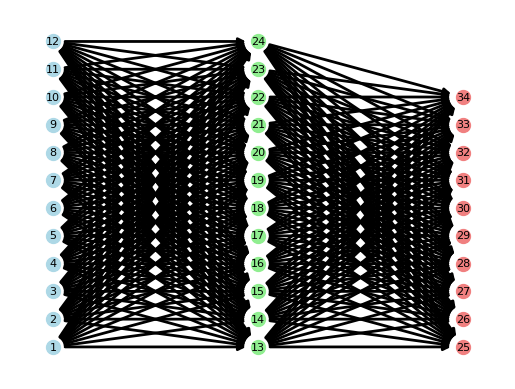

In [9]:
network.visualize()

### 8. Test various unstructured architectures

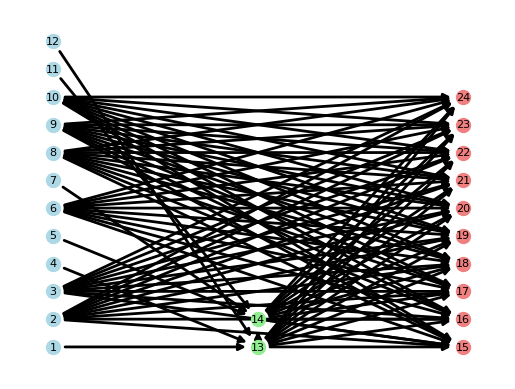

In [10]:
from snn import SNN
snn = SNN()

for i in range(7):
    snn.create_node('Relu', 784, 'input')
#print(network.input_neurons[0].input_size, len(network.input_neurons))

node_8 = snn.create_node('Relu', 0, 'hidden')
snn.add_connection(1, node_8)

node_9 = snn.create_node('Relu', 0, 'hidden')
snn.add_connection(2, node_9)

snn.add_connection(2, 5)


node_10 = snn.create_node('Relu', 0, 'hidden')


node_11 = snn.create_node('Relu', 0, 'hidden')
snn.add_connection(3, node_11)

node_12 = snn.create_node('Relu', 0, 'hidden')
snn.add_connection(3, node_12)

node_13 = snn.create_node('Relu', 0, 'hidden')
snn.add_connection(4, node_13)

node_14 = snn.create_node('Relu', 0, 'hidden')
snn.add_connection(5, node_14)

node_15 = snn.create_node('Relu', 0, 'hidden')
snn.add_connection(6, node_15)

snn.add_connection(4, new_node)
snn.add_connection(12, new_node)

newer_node = snn.create_node('Relu', 0, 'hidden')
snn.add_connection(new_node, newer_node)
snn.add_connection(5, newer_node)
snn.add_connection(7, newer_node)
snn.add_connection(11, newer_node)

for i in range(10):
    snn.create_node('None', 0, 'output')

for node in snn.output_nodes:
    snn.add_connection(2, node)
    snn.add_connection(3, node)
    snn.add_connection(6, node)
    snn.add_connection(8, node)
    snn.add_connection(9, node)
    snn.add_connection(10, node)
    snn.add_connection(new_node, node)
    snn.add_connection(newer_node, node)

'''
for i in range(12):
    new_node = snn.create_node('Relu', 0, 'hidden')
    for node in snn.input_nodes:
        snn.add_connection(node, new_node)

for i in range(10):
    new_node = snn.create_node('None', 0, 'output')

    for node in snn.hidden_nodes:
        snn.add_connection(node, new_node)
'''

snn.visualize()
snn.compile()

In [11]:
import tensorflow as tf
import cupy as cp
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
x_train = x_train / 255.0
x_test = x_test / 255.0

#flatten the dataset
x_train_flat = x_train.reshape(x_train.shape[0], 28 * 28).T
x_test_flat = x_test.reshape(x_test.shape[0], 28 * 28).T

#append 1s to multiply with biases
#ones_column = cp.ones((x_train_flat.shape[0], 1))
#x_train_flat = cp.hstack((ones_column, x_train_flat)).T

train_size = int(0.8 * x_train_flat.shape[1])  # 48000

x_val = x_train_flat[:, train_size:]     # Last 12000 columns for validation
x_train_flat = x_train_flat[:, :train_size]   # First 48000 columns for training
print("X_train Shape: ", x_train_flat.shape)
print("X_Val Shape: ", x_val.shape)

#ones_column = cp.ones((x_test_flat.shape[0], 1))
#x_test_flat = cp.hstack((ones_column, x_test_flat)).T
print("X_test Shape: ", x_test_flat.shape)

y_train = cp.eye(10)[y_train].T #convert to one hot encoded vectors

y_val = y_train[:, train_size:]
y_train = y_train[:, :train_size]

print("Y_Train Shape: ", y_train.shape)
print("Y_Val Shape: ", y_val.shape)

y_test = cp.eye(10)[y_test].T #convert to one hot encoded vectors
print("Y_Test Shape: ", y_test.shape)

epochs = 5
batch_size = 40

snn.execute(epochs, batch_size, x_train_flat, y_train, x_val, y_val, x_test_flat, y_test)

X_train Shape:  (784, 48000)
X_Val Shape:  (784, 12000)
X_test Shape:  (784, 10000)
Y_Train Shape:  (10, 48000)
Y_Val Shape:  (10, 12000)
Y_Test Shape:  (10, 10000)
Epoch: 1 Total Time: 30.4544 Average Time per batch: 0.0254 Train Accuracy: 0.8500 Train Loss: 0.3945 Val Accuracy: 0.8645 Val Loss: 6.1528
Epoch: 2 Total Time: 30.4295 Average Time per batch: 0.0254 Train Accuracy: 0.8750 Train Loss: 0.3189 Val Accuracy: 0.8939 Val Loss: 5.9485
Epoch: 3 Total Time: 30.4433 Average Time per batch: 0.0254 Train Accuracy: 0.9000 Train Loss: 0.2875 Val Accuracy: 0.9016 Val Loss: 5.9913
Epoch: 4 Total Time: 30.4287 Average Time per batch: 0.0254 Train Accuracy: 0.9250 Train Loss: 0.2640 Val Accuracy: 0.9057 Val Loss: 5.6746
Epoch: 5 Total Time: 30.4377 Average Time per batch: 0.0254 Train Accuracy: 0.9000 Train Loss: 0.2460 Val Accuracy: 0.9084 Val Loss: 5.5583
Test Accuracy:  0.9066 Test Loss:  5.864815168498282


### 9. Fully Connected Dense Unstructured Architecture

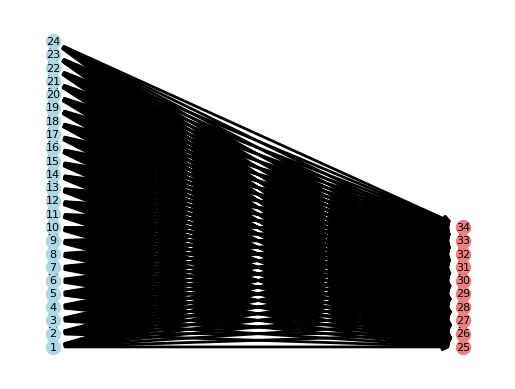

In [3]:
from snn import SNN

network = SNN()

for i in range(24):
    network.create_node('Relu', 784, 'input')
#print(network.input_neurons[0].input_size, len(network.input_neurons))

for i in range(1, 24):
    for j in range(i + 1, 25):
        network.add_connection(i, j)

for i in range(10):
    new_node = network.create_node('None', 0, 'output')

    for node in network.input_nodes:
        network.add_connection(node, new_node)
        
for i in range(25, 34):
    for j in range(i + 1, 35):
        network.add_connection(i, j)

network.compile()
network.visualize()

In [4]:
import tensorflow as tf
import cupy as cp
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
x_train = x_train / 255.0
x_test = x_test / 255.0

#flatten the dataset
x_train_flat = x_train.reshape(x_train.shape[0], 28 * 28).T
x_test_flat = x_test.reshape(x_test.shape[0], 28 * 28).T

#append 1s to multiply with biases
#ones_column = cp.ones((x_train_flat.shape[0], 1))
#x_train_flat = cp.hstack((ones_column, x_train_flat)).T

train_size = int(0.8 * x_train_flat.shape[1])  # 48000

x_val = x_train_flat[:, train_size:]     # Last 12000 columns for validation
x_train_flat = x_train_flat[:, :train_size]   # First 48000 columns for training
print("X_train Shape: ", x_train_flat.shape)
print("X_Val Shape: ", x_val.shape)

#ones_column = cp.ones((x_test_flat.shape[0], 1))
#x_test_flat = cp.hstack((ones_column, x_test_flat)).T
print("X_test Shape: ", x_test_flat.shape)

y_train = cp.eye(10)[y_train].T #convert to one hot encoded vectors

y_val = y_train[:, train_size:]
y_train = y_train[:, :train_size]

print("Y_Train Shape: ", y_train.shape)
print("Y_Val Shape: ", y_val.shape)

y_test = cp.eye(10)[y_test].T #convert to one hot encoded vectors
print("Y_Test Shape: ", y_test.shape)

epochs = 10
batch_size = 40

network.execute(epochs, batch_size, x_train_flat, y_train, x_val, y_val, x_test_flat, y_test)

X_train Shape:  (784, 48000)
X_Val Shape:  (784, 12000)
X_test Shape:  (784, 10000)
Y_Train Shape:  (10, 48000)
Y_Val Shape:  (10, 12000)
Y_Test Shape:  (10, 10000)


Epoch: 1 Total Time: 97.4319 Average Time per batch: 0.0812 Train Accuracy: 0.9000 Train Loss: 0.2680 Val Accuracy: 0.9216 Val Loss: 0.0859
Epoch: 2 Total Time: 94.9605 Average Time per batch: 0.0791 Train Accuracy: 0.9000 Train Loss: 0.2186 Val Accuracy: 0.9382 Val Loss: 0.0663
Epoch: 3 Total Time: 89.1260 Average Time per batch: 0.0743 Train Accuracy: 0.9000 Train Loss: 0.1981 Val Accuracy: 0.9448 Val Loss: 0.0589
Epoch: 4 Total Time: 82.6481 Average Time per batch: 0.0689 Train Accuracy: 0.9500 Train Loss: 0.1377 Val Accuracy: 0.9491 Val Loss: 0.0458
Epoch: 5 Total Time: 82.5877 Average Time per batch: 0.0688 Train Accuracy: 0.9750 Train Loss: 0.1129 Val Accuracy: 0.9503 Val Loss: 0.0475
Epoch: 6 Total Time: 82.7522 Average Time per batch: 0.0690 Train Accuracy: 0.9500 Train Loss: 0.0959 Val Accuracy: 0.9532 Val Loss: 0.0472
Epoch: 7 Total Time: 82.7840 Average Time per batch: 0.0690 Train Accuracy: 0.9750 Train Loss: 0.0827 Val Accuracy: 0.9561 Val Loss: 0.0402
Epoch: 8 Total Time:

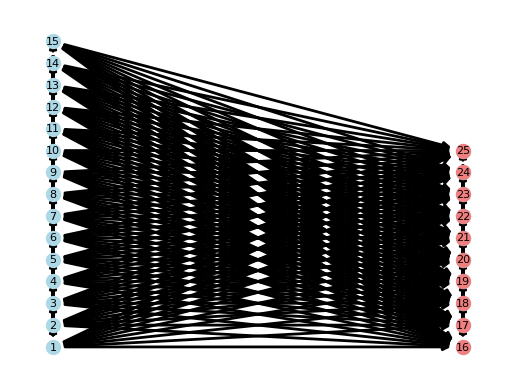

In [9]:
from snn import SNN
import cupy as cp

network = SNN()
cp.random.seed(42)

num_nodes = 10

for i in range(num_nodes):
    network.create_node('Relu', 784, 'input')
#print(network.input_neurons[0].input_size, len(network.input_neurons))

for i in range(1, num_nodes):
    for j in range(i + 1, num_nodes + 1):
        network.add_connection(i, j)

inputs = network.input_nodes.copy()
for i in range(10):
    new_node = network.create_node('None', 784, 'input')
    network.output_nodes.append(new_node)
    network.vertices[new_node].output_size = 1

    for node in inputs:
        network.add_connection(node, new_node)
        
for i in range(num_nodes + 1, num_nodes + 10):
    for j in range(i + 1, num_nodes + 11):
        network.add_connection(i, j)

network.compile()
network.visualize()

In [10]:
import tensorflow as tf
import cupy as cp
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
x_train = x_train / 255.0
x_test = x_test / 255.0

#flatten the dataset
x_train_flat = x_train.reshape(x_train.shape[0], 28 * 28).T
x_test_flat = x_test.reshape(x_test.shape[0], 28 * 28).T

#append 1s to multiply with biases
#ones_column = cp.ones((x_train_flat.shape[0], 1))
#x_train_flat = cp.hstack((ones_column, x_train_flat)).T

train_size = int(0.8 * x_train_flat.shape[1])  # 48000

x_val = x_train_flat[:, train_size:]     # Last 12000 columns for validation
x_train_flat = x_train_flat[:, :train_size]   # First 48000 columns for training
print("X_train Shape: ", x_train_flat.shape)
print("X_Val Shape: ", x_val.shape)

#ones_column = cp.ones((x_test_flat.shape[0], 1))
#x_test_flat = cp.hstack((ones_column, x_test_flat)).T
print("X_test Shape: ", x_test_flat.shape)

y_train = cp.eye(10)[y_train].T #convert to one hot encoded vectors

y_val = y_train[:, train_size:]
y_train = y_train[:, :train_size]

print("Y_Train Shape: ", y_train.shape)
print("Y_Val Shape: ", y_val.shape)

y_test = cp.eye(10)[y_test].T #convert to one hot encoded vectors
print("Y_Test Shape: ", y_test.shape)

epochs = 15
batch_size = 40

network.execute(epochs, batch_size, x_train_flat, y_train, x_val, y_val, x_test_flat, y_test)

X_train Shape:  (784, 48000)
X_Val Shape:  (784, 12000)
X_test Shape:  (784, 10000)
Y_Train Shape:  (10, 48000)
Y_Val Shape:  (10, 12000)
Y_Test Shape:  (10, 10000)
Epoch: 1 Total Time: 50.6242 Average Time per batch: 0.0422 Train Accuracy: 0.9250 Train Loss: 0.2633 Val Accuracy: 0.9243 Val Loss: 0.2395
Epoch: 2 Total Time: 50.5951 Average Time per batch: 0.0422 Train Accuracy: 0.9250 Train Loss: 0.2298 Val Accuracy: 0.9378 Val Loss: 0.2300
Epoch: 3 Total Time: 50.6533 Average Time per batch: 0.0422 Train Accuracy: 0.9250 Train Loss: 0.2045 Val Accuracy: 0.9449 Val Loss: 0.2445
Epoch: 4 Total Time: 50.6593 Average Time per batch: 0.0422 Train Accuracy: 0.9250 Train Loss: 0.1900 Val Accuracy: 0.9493 Val Loss: 0.2649
Epoch: 5 Total Time: 50.6694 Average Time per batch: 0.0422 Train Accuracy: 0.9500 Train Loss: 0.1719 Val Accuracy: 0.9514 Val Loss: 0.2990
Epoch: 6 Total Time: 50.6447 Average Time per batch: 0.0422 Train Accuracy: 0.9500 Train Loss: 0.1709 Val Accuracy: 0.9541 Val Loss: 0.